In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd

import time
import copy
import os
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)



PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


In [25]:
from torch.utils.tensorboard import SummaryWriter

2023-07-11 17:07:44.650236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 17:07:49.673279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-11 17:07:58.586304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/shsingh/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-07-11 17:07:58.587348: W tensor

In [2]:
print(torch.cuda.max_memory_allocated())
torch.cuda.empty_cache()

0


## Data preprocessing

In [2]:
os.getcwd()

'/project/shsingh/knowledge_distillation/notebooks'

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
print(torch.cuda.memory_summary()) 

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
# device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus


# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
torch.cuda.current_device()
torch.cuda.get_device_name()
torch.cuda.mem_get_info(device=device)

(10978197504, 11546394624)

In [17]:
df = pd.read_csv('/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/meta_data_mapping.csv')
#  /home/shsingh/knowledge_distillation/dataset/scratch/dataframes/meta_data_mapping.csv
# del df['Unnamed: 0']
# df = df[df.label_flair != 'discard']
# df

In [18]:
df

,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2
0,BraTS20_Training_001,BraTS20_Training_001_seg_0,/home/shsingh/knowledge_distillation/knowledge...,discard,discard,discard,discard
1,BraTS20_Training_001,BraTS20_Training_001_seg_1,/home/shsingh/knowledge_distillation/knowledge...,discard,discard,discard,discard
2,BraTS20_Training_001,BraTS20_Training_001_seg_10,/home/shsingh/knowledge_distillation/knowledge...,healthy,healthy,healthy,healthy
3,BraTS20_Training_001,BraTS20_Training_001_seg_100,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG
4,BraTS20_Training_001,BraTS20_Training_001_seg_101,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG
...,...,...,...,...,...,...,...
57190,BraTS20_Training_369,BraTS20_Training_369_seg_95,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG
57191,BraTS20_Training_369,BraTS20_Training_369_seg_96,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG
57192,BraTS20_Training_369,BraTS20_Training_369_seg_97,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG
57193,BraTS20_Training_369,BraTS20_Training_369_seg_98,/home/shsingh/knowledge_distillation/knowledge...,HGG,HGG,HGG,HGG


In [19]:
print(df.iloc[0, 0])
print(df.iloc[0, 1])
print(df.iloc[0, 2])

BraTS20_Training_001
BraTS20_Training_001_seg_0
/home/shsingh/knowledge_distillation/knowledge_distillation/dataset/scratch/MICCAI_BraTS20_trainigdata_npz/BraTS20_Training_001/BraTS20_Training_001_seg/BraTS20_Training_001_seg_0.npy


In [20]:

training_df, test_df = train_test_split(df ,test_size = 0.12, random_state = 42, shuffle = True)
train_df , val_df = train_test_split(training_df,test_size = 0.2, random_state = 42, shuffle = True)


healthy    18665
HGG        13698
discard     4427
LGG         3434
Name: label_flair, dtype: int64


<AxesSubplot: >

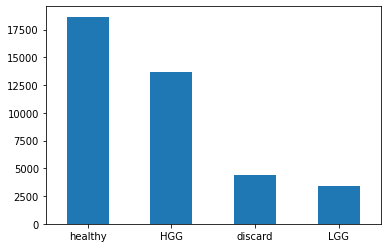

In [22]:
print(train_df['label_flair'].value_counts())
train_df['label_flair'].value_counts().plot.bar(x='lab', y='#samples', rot=0)

healthy    4682
HGG        3381
discard    1149
LGG         846
Name: label_flair, dtype: int64


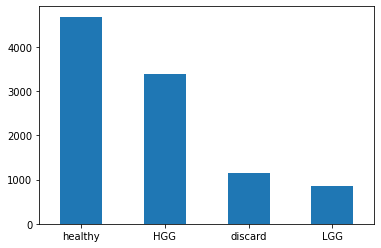

In [23]:
val_df['label_flair'].value_counts().plot.bar(x='lab', y='#samples', rot=0)
print(val_df['label_flair'].value_counts())

healthy    3172
HGG        2402
discard     720
LGG         564
Name: label_flair, dtype: int64


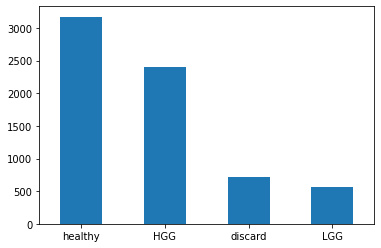

In [24]:
test_df['label_flair'].value_counts().plot.bar(x='lab', y='#samples', rot=0)
print(test_df['label_flair'].value_counts())

In [16]:
image_path = 'knowledge_distillation/dataset/scratch/MICCAI_BraTS2020_TrainingData_2D/'
image_size = 240
num_classes = 3

In [17]:

def class_to_idx(label):
    idx = 0
    if label == 'healthy':idx =0
    if label == 'HGG':idx =1
    if label=='LGG': idx = 2        
       
    return idx


class CustomImageDataset_from_csv(Dataset):
    def __init__(self, dataframe , img_dir ,  transform = None , label_transform =  None):
        self.img_labels = dataframe #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self , idx):
        img_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, 0],self.img_labels.iloc[idx, 0]+ '_flair', self.img_labels.iloc[idx, 1])
#         print(img_path)
#         image = read_image(img_path)
        image = Image.open(img_path)  
        
        label = self.img_labels.iloc[idx, 2]
        label = class_to_idx(label)
        label = torch.tensor([label])
                             
        
        if self.transform is not None:
            image = self.transform(image)
        if self.label_transform:
            label = self.target_transform(label)
            
#         print('Image shape : ',np.shape(image))
#         print('label shape : ',np.shape(label))
        
        return(image, label )

In [18]:
train_data = CustomImageDataset_from_csv(train_df , image_path)

val_data = CustomImageDataset_from_csv(val_df , image_path)


test_data = CustomImageDataset_from_csv(test_df , image_path)

In [18]:
train_data = CustomImageDataset_from_csv(train_df , image_path,
           transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                    transforms.Normalize((0.5, ), (0.5, ))
                               ]))

val_data = CustomImageDataset_from_csv(val_df , image_path,
         transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                     transforms.Normalize((0.5, ), (0.5, ))
                               ]))


test_data = CustomImageDataset_from_csv(test_df , image_path,
          transform=transforms.Compose([
                                   transforms.Resize((image_size, image_size)), 
                                   transforms.ToTensor()
#                                     transforms.Normalize((0.5, ), (0.5, ))                              
                               ]))

In [19]:
print("Shape of trainig data :",train_data.img_labels.shape)
print("Shape of validation data :",val_data.img_labels.shape)
print("Shape of test data :",test_data.img_labels.shape)

Shape of trainig data : (35686, 3)
Shape of validation data : (8922, 3)
Shape of test data : (6084, 3)


In [20]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)

test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

torch.Size([64, 1, 240, 240])


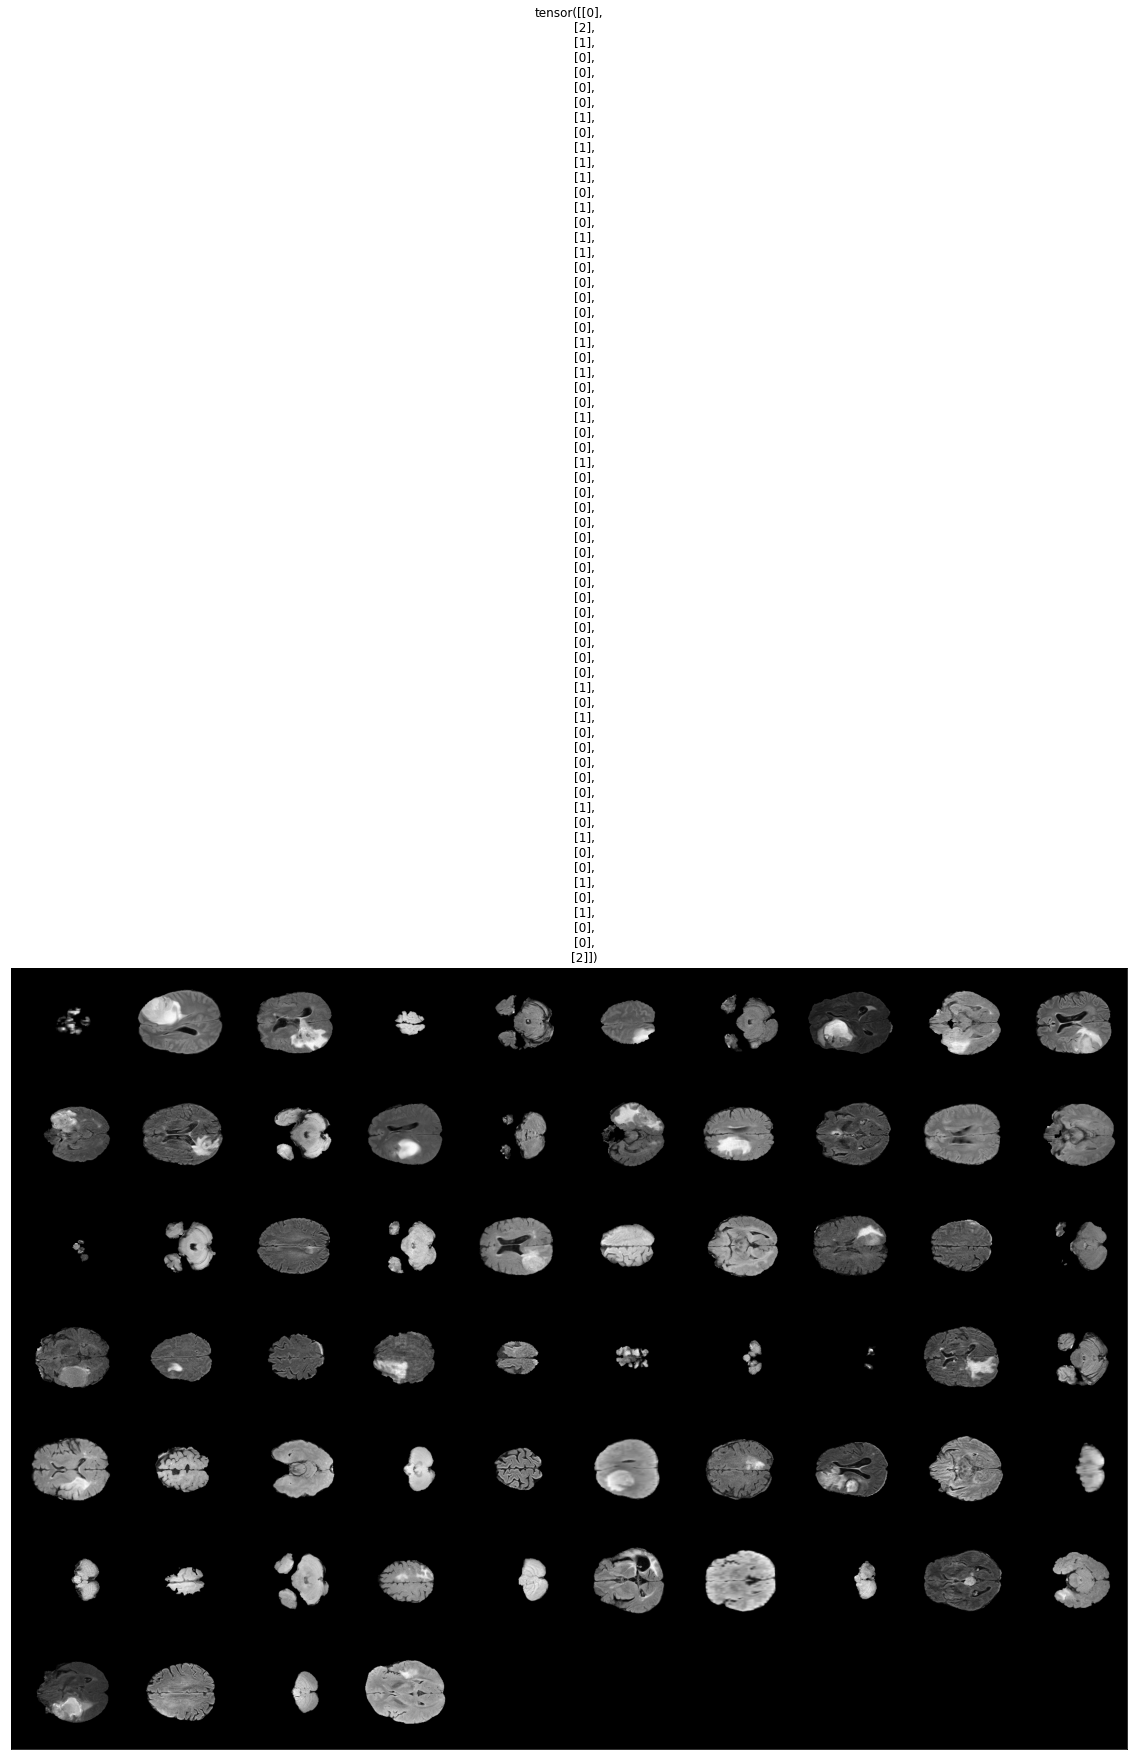

In [21]:
for images, labels in train_dataloader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    print(np.shape(images))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    ax.set_title((labels))
    break
    
    
# print(np.shape(labels[0]))

In [23]:
classes =['healthy', 'HGG', 'LGG']

# Model

In [22]:
from resnet import ResNet18, ResNet50, ResNet101
# model = ResNet18()
model = ResNet50()
model.fc = nn.Sequential(
            nn.Linear(2048, 3, bias = True),
#             nn.ReLU(),
#             nn.Linear(512, 3, bias = True)
            )
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [25]:
summary(model, inpit_size = (1,240,240))


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─block: 2-1                        --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─block: 2-2                        --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─block: 2-1                        --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─block: 2-2                        --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

In [23]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

# PATH = ''

def load_model_checkpoint(PATH):    
    #Loading model-checkpoints to continue training
    model = ResNet50()
    model.fc = nn.Sequential(
                nn.Linear(2048, 3, bias = True),
                )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    n_epochs = checkpoint['epoch']
    loss = checkpoint['loss']
    lr_scheduler = checkpoint['lr']
    
    return model, n_epochs, loss, lr_scheduler
    
    


In [24]:
def accuracy(out, labels):
    print("output_softmax: ",out)
    print("output_shape: ", np.shape(out))
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [26]:
n_epochs = 35
print_every = 5

valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []

total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    lr_scheduler.step()
    
    print(f'Epoch {epoch}\n')
    print('LR:', lr_scheduler.get_lr())
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_= data_.to(device), target_.to(torch.int64)
        target_ = target_.squeeze_().to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
#         outputs = torch.argmax(outputs ,axis=1)
        outputs.to(torch.float32)
        
#         print(outputs)
#         print("outs: ",np.shape(outputs))
#         print("Targets: ",np.shape(target_))
        loss = criterion(outputs, target_)
#         print("LOSS: ",loss)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(torch.int64)
            
            target_t = target_t.squeeze_().to(device)
            
            
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save({'epoch': n_epochs,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr': lr_scheduler.state_dict(),
                        'loss': loss }
                       ,'models/resnet50_teach_model_35ep.pt')
            
            print('Improvement-Detected, save-model')
    model.train()
    

/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/shsingh/knowledge_distillation/myenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1

LR: [0.0001]
Epoch [1/35], Step [0/558], Loss: 1.1216
Epoch [1/35], Step [50/558], Loss: 0.5087
Epoch [1/35], Step [100/558], Loss: 0.5283
Epoch [1/35], Step [150/558], Loss: 0.4718
Epoch [1/35], Step [200/558], Loss: 0.4449
Epoch [1/35], Step [250/558], Loss: 0.4896
Epoch [1/35], Step [300/558], Loss: 0.5252
Epoch [1/35], Step [350/558], Loss: 0.4560
Epoch [1/35], Step [400/558], Loss: 0.4795
Epoch [1/35], Step [450/558], Loss: 0.3841
Epoch [1/35], Step [500/558], Loss: 0.5946
Epoch [1/35], Step [550/558], Loss: 0.4139

train-loss: 0.5017, train-acc: 77.9493
validation loss: 0.7295, validation acc: 78.0206

Improvement-Detected, save-model
Epoch 2

LR: [9.62964972193618e-39]
Epoch [2/35], Step [0/558], Loss: 0.5036
Epoch [2/35], Step [50/558], Loss: 0.4864
Epoch [2/35], Step [100/558], Loss: 0.4007
Epoch [2/35], Step [150/558], Loss: 0.3870
Epoch [2/35], Step [200/558], Loss: 0.5668
Epoch [2/35], Step [250/558], Loss: 0.4594
Epoch [2/35], Step [300/558], Loss: 0.4494
Epoch [2

Epoch [13/35], Step [500/558], Loss: 0.4881
Epoch [13/35], Step [550/558], Loss: 0.4715

train-loss: 0.4972, train-acc: 78.3585
validation loss: 0.7297, validation acc: 78.0767

Epoch 14

LR: [0.0]
Epoch [14/35], Step [0/558], Loss: 0.3791
Epoch [14/35], Step [50/558], Loss: 0.5513
Epoch [14/35], Step [100/558], Loss: 0.4461
Epoch [14/35], Step [150/558], Loss: 0.4853
Epoch [14/35], Step [200/558], Loss: 0.3976
Epoch [14/35], Step [250/558], Loss: 0.5860
Epoch [14/35], Step [300/558], Loss: 0.5146
Epoch [14/35], Step [350/558], Loss: 0.4940
Epoch [14/35], Step [400/558], Loss: 0.4509
Epoch [14/35], Step [450/558], Loss: 0.5016
Epoch [14/35], Step [500/558], Loss: 0.4670
Epoch [14/35], Step [550/558], Loss: 0.2873

train-loss: 0.4971, train-acc: 78.2183
validation loss: 0.7297, validation acc: 78.0430

Epoch 15

LR: [0.0]
Epoch [15/35], Step [0/558], Loss: 0.3587
Epoch [15/35], Step [50/558], Loss: 0.6098
Epoch [15/35], Step [100/558], Loss: 0.5640
Epoch [15/35], Step [150/558], Loss: 0

Epoch [26/35], Step [450/558], Loss: 0.5423
Epoch [26/35], Step [500/558], Loss: 0.4460
Epoch [26/35], Step [550/558], Loss: 0.6503

train-loss: 0.4969, train-acc: 78.3613
validation loss: 0.7294, validation acc: 78.0206

Epoch 27

LR: [0.0]
Epoch [27/35], Step [0/558], Loss: 0.5039
Epoch [27/35], Step [50/558], Loss: 0.5265
Epoch [27/35], Step [100/558], Loss: 0.3870
Epoch [27/35], Step [150/558], Loss: 0.4887
Epoch [27/35], Step [200/558], Loss: 0.5581
Epoch [27/35], Step [250/558], Loss: 0.4371
Epoch [27/35], Step [300/558], Loss: 0.7420
Epoch [27/35], Step [350/558], Loss: 0.6176
Epoch [27/35], Step [400/558], Loss: 0.4614
Epoch [27/35], Step [450/558], Loss: 0.6097
Epoch [27/35], Step [500/558], Loss: 0.4253
Epoch [27/35], Step [550/558], Loss: 0.4143

train-loss: 0.4969, train-acc: 78.3220
validation loss: 0.7294, validation acc: 78.0767

Epoch 28

LR: [0.0]
Epoch [28/35], Step [0/558], Loss: 0.4991
Epoch [28/35], Step [50/558], Loss: 0.4511
Epoch [28/35], Step [100/558], Loss: 0

In [ ]:
# Additional information
EPOCH = 5
PATH = "model.pt"
LOSS = 0.4

torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

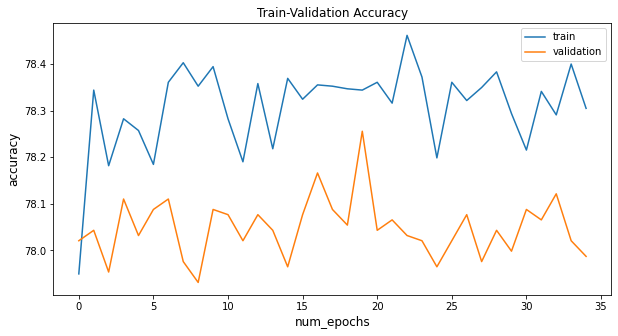

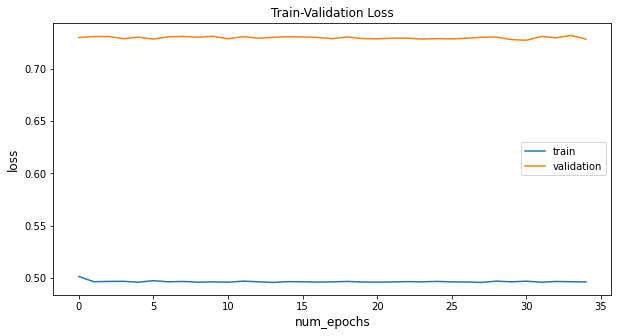

In [27]:
fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')


fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [59]:
torch.save(model.state_dict(), 'models/resnet18_base_model_20ep.pt')

# Evaluation/ Testing model

In [30]:
correct = 0
total = 0

model.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(predicted==labels).item()
        total_t += target_t.size(0)
        
print(correct)        
print(total)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

239391
6084
Accuracy of the network on the 10000 test images: 3934 %


In [31]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

model.eval()
# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: healthy is 97.4 %
Accuracy for class: HGG   is 94.3 %
Accuracy for class: LGG   is 89.5 %


In [32]:
import tqdm

import seaborn as sns


y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [52]:
y_pred_list[0]

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        62
           1       1.00      0.90      0.95        29
           2       1.00      0.80      0.89         5

    accuracy                           0.96        96
   macro avg       0.98      0.90      0.93        96
weighted avg       0.96      0.96      0.96        96

[[62  0  0]
 [ 3 26  0]
 [ 1  0  4]]


<AxesSubplot: >

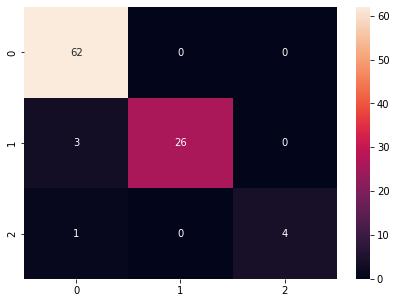

In [33]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))
# .rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [54]:
nb_classes = 3

model.eval()

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[4.4550e+03, 9.6000e+01, 7.0000e+00],
        [7.8000e+01, 1.2660e+03, 1.0000e+00],
        [2.8000e+01, 8.0000e+00, 1.4500e+02]])
tensor([0.9774, 0.9413, 0.8011])


In [55]:
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import auc

def get_confusion_metrics(preds, target):    
    
#     preds =torch.max(preds, dim=1)
    confmat = ConfusionMatrix(num_classes=3).to(device)
    
    print("Prediction: ", np.shape(preds))
    print("Ground truth: ",np.shape(target))
    return confmat(preds, target)
#     auc(preds, target, reorder=True)

#Trainig COnfusion metric
# get_confusion_metrics(preds, target)
get_confusion_metrics(outputs_t, target_t)

Prediction:  torch.Size([26, 3])
Ground truth:  torch.Size([26])


tensor([[16,  0,  0],
        [ 1,  9,  0],
        [ 0,  0,  0]], device='cuda:7')

In [56]:
def create_confusion_matrix(y_true, y_pred, classes):
    """ creates and plots a confusion matrix given two list (targets and predictions)
    :param list y_true: list of all targets (in this case integers bc. they are indices)
    :param list y_pred: list of all predictions (in this case one-hot encoded)
    :param dict classes: a dictionary of the countries with they index representation
    """

    amount_classes = len(classes)

    confusion_matrix = np.zeros((amount_classes, amount_classes))
    for idx in range(len(y_true)):
        target = y_true[idx][0]

        output = y_pred[idx]
        output = list(output).index(max(output))

        confusion_matrix[target][output] += 1

    fig, ax = plt.subplots(1)

    ax.matshow(confusion_matrix)
    ax.set_xticks(np.arange(len(list(classes.keys()))))
    ax.set_yticks(np.arange(len(list(classes.keys()))))

    ax.set_xticklabels(list(classes.keys()))
    ax.set_yticklabels(list(classes.keys()))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.show()

TypeError: can't convert cuda:7 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [58]:
use_cuda = True

In [60]:
def visualize_model(model, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.to(device), labels.squeeze_().to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
#             ax.set_title('predictes: {}'.format(test_dataloader.classes[preds[j]]))
            plt.imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(model)
plt.ioff()

RuntimeError: CUDA out of memory. Tried to allocate 226.00 MiB (GPU 7; 10.76 GiB total capacity; 9.06 GiB already allocated; 134.56 MiB free; 9.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<Figure size 1080x720 with 0 Axes>

TypeError: can't convert cuda:7 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# from resnet import ResNet18
# print(ResNet18)

# def test():
#     net = ResNet18(img_channel=1, num_classes=1000)
#     y = net(torch.randn(4, 1, 224, 224)).to("cuda")
#     print(y.size())
    
    
# test()

In [2]:
import pandas as pd
df_train = pd.read_csv("/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/train_df.csv")
df_val = pd.read_csv("/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/val_df.csv")
df_test = pd.read_csv("/home/shsingh/knowledge_distillation/dataset/scratch/dataframes/test_df.csv")

In [5]:
df_val

,Unnamed: 0,subject_id,image_idx,image_path,label_flair,label_t1,label_t1ce,label_t2,Brats20ID,Age,Survival_days,Extent_of_Resection
0,0,BraTS20_Training_017,BraTS20_Training_017_seg_1,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_017,58.258,439.0,GTR
1,1,BraTS20_Training_017,BraTS20_Training_017_seg_10,/home/shsingh/knowledge_distillation/dataset/s...,healthy,healthy,healthy,healthy,BraTS20_Training_017,58.258,439.0,GTR
2,2,BraTS20_Training_017,BraTS20_Training_017_seg_100,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_017,58.258,439.0,GTR
3,3,BraTS20_Training_017,BraTS20_Training_017_seg_101,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_017,58.258,439.0,GTR
4,4,BraTS20_Training_017,BraTS20_Training_017_seg_102,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_017,58.258,439.0,GTR
...,...,...,...,...,...,...,...,...,...,...,...,...
5114,5114,BraTS20_Training_358,BraTS20_Training_358_seg_95,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_358,61.000,300.0,GTR
5115,5115,BraTS20_Training_358,BraTS20_Training_358_seg_96,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_358,61.000,300.0,GTR
5116,5116,BraTS20_Training_358,BraTS20_Training_358_seg_97,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_358,61.000,300.0,GTR
5117,5117,BraTS20_Training_358,BraTS20_Training_358_seg_98,/home/shsingh/knowledge_distillation/dataset/s...,HGG,HGG,HGG,HGG,BraTS20_Training_358,61.000,300.0,GTR


In [11]:
df_val['label_flair'].value_counts(), df_train['label_flair'].value_counts(), df_test['label_flair'].value_counts()

(healthy    2670
 HGG        2042
 LGG         404
 Name: label_flair, dtype: int64,
 healthy    18506
 HGG        13523
 LGG         3510
 Name: label_flair, dtype: int64,
 healthy    5343
 HGG        3916
 LGG         930
 Name: label_flair, dtype: int64)

In [9]:
len(np.unique(df_val['subject_id'])), len(np.unique(df_train['subject_id'])), len(np.unique(df_test['subject_id']))

(37, 258, 74)

In [ ]:
label_flair